# Traded Climate Stress

In [1]:
# __authors__: Elizabeth Barnes, Patrick W. Keys, Noah Diffenbaugh, Tom Hertel, Uris Baldos and Johanna Hedlund
# __date__: October 3, 2023

In [2]:
import warnings
import importlib as imp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import experiment_settings
import data_processing
import plots
import cropstress
import climatedata

import palettable
import scipy.stats as stats
import cartopy as ct
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import seaborn as sns

warnings.filterwarnings("ignore")

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
FS = 10
plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
plt.rc("savefig", facecolor="white")
plt.rc("axes", facecolor="white")
plt.rc("axes", labelcolor="dimgrey")
plt.rc("axes", labelcolor="dimgrey")
plt.rc("xtick", color="dimgrey")
plt.rc("ytick", color="dimgrey")
map_proj = ct.crs.EqualEarth(central_longitude=0.0)

In [3]:
DATA_DIRECTORY = "/Users/eabarnes/big_data/"
PROCESSED_DIRECTORY = "processed_data/"
FIGURE_DIRECTORY = "figures/"
SHAPE_DIRECTORY = "shapefiles/gadm_shapefiles_20230301_gtapv11/"
CROP_DIRECTORY = "data/cropland/regridded_cropland/"
POPULATION_DIRECTORY = "data/population/SSP2/Total/NetCDF/"
PROCESSED_METRICS_DIRECTORY = "processed_metrics/"
SAVE_DATA = True
REWRITE = False

EXP_NAME = "exp301"

In [4]:
# TODO: Cleanup figures

## PERFORM ANALYSIS

In [5]:
# GET THE CLIMATE DATA and MASKS
settings = experiment_settings.get_settings(EXP_NAME)
crop_name = cropstress.crop_name(settings["product"])
mask_country, regs_shp = data_processing.get_country_masks(
    settings, SHAPE_DIRECTORY, DATA_DIRECTORY
)

data = climatedata.get_climate_data(settings, rewrite=REWRITE, save=SAVE_DATA)

loading shapefiles/gadm_shapefiles_20230301_gtapv11/countries_10m_cesm2.nc
processed_data/exp201_processed_data.nc: loading saved data.
final samples.shape = (100, 192, 288)


In [6]:
# ANALYZE TRADE DATA
imp.reload(cropstress)
(
    reporter_code_list,
    traded_stress,
    unweighted_stress,
    df_stress,
    df_metrics,
) = cropstress.get_processed_metrics(data, settings, rewrite=REWRITE, save=SAVE_DATA)

   loading pre-saved data from processed_metrics/exp301_processed_metrics.pickle


In [7]:
# Fill the maps

map_summary = data.copy() * 0.0
map_r = np.zeros((data.shape[1], data.shape[2]))
map_rtoptwo = np.zeros((data.shape[1], data.shape[2]))

for irep, reporter_code in enumerate(reporter_code_list):
    mask_reporter = data_processing.create_country_mask(
        reporter_code, regs_shp, mask_country
    )
    # print(data_processing.get_name_from_code((reporter_code,)))

    map_summary = cropstress.fill_map(
        map_summary, mask_reporter, np.asarray(df_stress.loc[reporter_code])
    )
    map_r = cropstress.fill_map(
        map_r, mask_reporter, df_metrics.loc[reporter_code]["corr_localtotal"]
    )
    map_rtoptwo = cropstress.fill_map(
        map_rtoptwo, mask_reporter, df_metrics.loc[reporter_code]["corr_toptwo"]
    )

# finalize map and mask zero to nans
map_summary = xr.where(map_summary == 0.0, np.nan, map_summary)
map_r = xr.where(map_r == 0.0, np.nan, map_r)
map_rtoptwo = xr.where(map_rtoptwo == 0.0, np.nan, map_rtoptwo)

## PLOT RESULTS

54 1.3
99 51.3


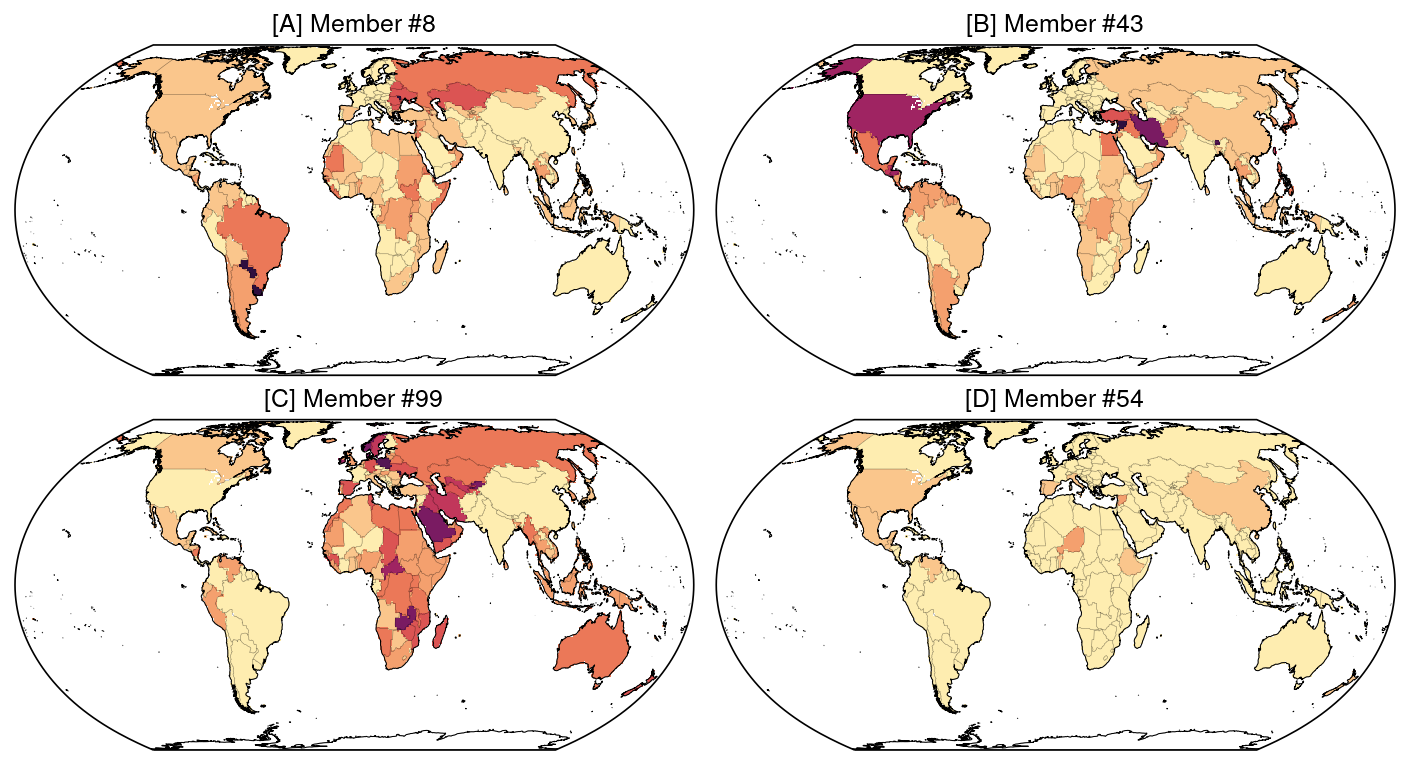

In [8]:
imp.reload(plots)
import string
from matplotlib import colors

cmap = palettable.cmocean.sequential.Matter_10.mpl_colormap
cmap_stress = palettable.cmocean.sequential.Amp_10.mpl_colormap
cmap_trade = palettable.cmocean.sequential.Speed_20.mpl_colormap

# ------------------------
THRESHOLD = 0.20
# compute the worst and best case scenarios
x = np.where(np.nansum(traded_stress, axis=(2,)) > THRESHOLD, 1, 0)
imin_member = np.argmin(x.sum(axis=0))
min_member = np.min(x.sum(axis=0)) / traded_stress.shape[0]
print(imin_member, (min_member*100).round(1))

x = np.where(np.nansum(traded_stress, axis=(2,)) > THRESHOLD, 1, 0)
imax_member = np.argmax(x.sum(axis=0))
max_member = np.max(x.sum(axis=0)) / traded_stress.shape[0]
print(imax_member, (max_member*100).round(1))
# ------------------------

members_to_plot = (
    8,
    43,
    imax_member,
    imin_member,
)

vscale = 100.0
norm = colors.BoundaryNorm(np.arange(0.0, vscale + 10, 10), cmap.N)

n_plot_members = len(members_to_plot)
fig = plt.figure(figsize=(4.75 * 2.0, 3.0 * 1.75), dpi=150)

for isample, sample in enumerate(members_to_plot):
    ax = fig.add_subplot(2, 2, isample + 1, projection=map_proj)
    plots.drawOnGlobe(
        ax,
        map_proj,
        data=map_summary[sample, :, :] * 100,
        lats=data.lat,
        lons=data.lon,
        fastBool=True,
        cmap=cmap,
        vmin=0.0,
        vmax=vscale,
        cbarBool=False,
        extent="neither",
        norm=norm,
    )
    ax.set_title("[" + string.ascii_uppercase[isample] + "] Member \#" + str(data[sample]["sample"]["member"].values))

plt.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_"
    + settings["product"]
    + "_summary_imported_stress"
)
plots.savefig(
    FIGURE_DIRECTORY
    + "figure2_"
    + settings["exp_name"]
    + "_"
    + settings["product"]
    + "_summary_imported_stress",
    fig_format=(".png", ".pdf"),
)
plt.show()

In [9]:
raise ValueError()

ValueError: 

In [ ]:
imp.reload(plots)
from matplotlib import colors

# cmap_corr = colors.ListedColormap(palettable.colorbrewer.diverging.RdBu_11_r.mpl_colors)
cmap_corr = plt.get_cmap("twilight_shifted", 11)
fig = plt.figure(figsize=(5.0 * 2.0 * 1.25, 3.0 * 1 * 1.25), dpi=200)

ax = fig.add_subplot(1, 2, 1, projection=map_proj)
vscale = 0.55
plots.drawOnGlobe(
    ax,
    map_proj,
    data=map_r,
    lats=data.lat,
    lons=data.lon,
    fastBool=True,
    cmap=cmap_corr,
    vmin=-vscale,
    vmax=vscale,
    cbarBool=True,
    extent="neither",
)
ax.set_title(crop_name + ": correlation of local and non-local-total imports")

ax = fig.add_subplot(1, 2, 2, projection=map_proj)
plots.drawOnGlobe(
    ax,
    map_proj,
    data=map_rtoptwo,
    lats=data.lat,
    lons=data.lon,
    fastBool=True,
    cmap=cmap_corr,
    vmin=-vscale,
    vmax=vscale,
    cbarBool=True,
    extent="neither",
)
ax.set_title(crop_name + ": correlation of top two importers")

plt.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_"
    + settings["product"]
    + "_imported_local_stress_metrics"
)
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

hierarchy.set_link_color_palette(
    [
        "gold",
        "mediumpurple",
        "sandybrown",
        "mediumseagreen",
        "mediumblue",
        "crimson",
        "sienna",
    ]
)

imp.reload(plots)
x_data = np.nansum(traded_stress, axis=-1)
x_data = x_data.swapaxes(1, 0)
# x_data = np.where(x_data == 0, np.nan, x_data)

model = []
model_full = AgglomerativeClustering(
    n_clusters=None,
    metric="euclidean",
    linkage="ward",
    distance_threshold=0.0,
    compute_full_tree=True,
).fit(x_data)
model = AgglomerativeClustering(
    n_clusters=7, metric="euclidean", linkage="ward", distance_threshold=None
).fit(x_data)
n_clusters = len(np.unique(model.labels_))
classes = model.labels_

plt.figure(figsize=(12, 4))
plots.plot_dendrogram(
    model_full,
    truncate_mode=None,
    color_threshold=4.0,
    get_leaves=True,
    distance_sort="ascending",
    above_threshold_color="gray",
)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.yticks([])
plt.xlabel("member")
plt.tight_layout()
plt.title(f"{crop_name}")
plots.savefig(
    FIGURE_DIRECTORY + settings["exp_name"] + "_dendrogram_" + settings["product"]
)
plt.show()

In [ ]:
# PLOT THE RESULTS
# TODO: ValueError("this seems wrong")

vmin, vmax = 0.0, 0.6
multiplier = 1
cmap = palettable.cubehelix.cubehelix1_16_r.mpl_colors
cmap = ListedColormap(cmap[1:-2])
# norm = colors.BoundaryNorm(np.arange(vmin, vmax + 0.1 * multiplier, 0.1 * multiplier), cmap.N)

fig = plt.figure(figsize=(4.375 * n_clusters, 3.0), dpi=200)
for icluster in range(n_clusters):
    j = np.where(classes == icluster)[0]

    ax = fig.add_subplot(1, n_clusters, icluster + 1, projection=map_proj)

    data_plot = np.nanmean(map_summary[j, :, :], axis=0)

    cb, image = plots.drawOnGlobe(
        ax,
        map_proj,
        data=data_plot * multiplier,
        lats=data.lat,
        lons=data.lon,
        fastBool=True,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        # norm=norm,
        cbarBool=True,
        extent="max",
    )
    cb.ax.set_xlabel("fraction under stress")
    cb.ax.tick_params(labelsize=6)
    ax.set_title(f"{crop_name}: cluster {icluster}; N = {len(j)}")

plt.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_summary_"
    + settings["product"]
    + "_clusters"
    + str(n_clusters)
)
# plt.close()
plt.show()

In [ ]:
# PLOT SPECIFIC GROUPS OF CLUSTERS
vmin, vmax = 0.0, 0.6
multiplier = 1
cmap = palettable.cubehelix.cubehelix1_16_r.mpl_colors
cmap = ListedColormap(cmap[1:-2])
# norm = colors.BoundaryNorm(np.arange(vmin, vmax + 0.1 * multiplier, 0.1 * multiplier), cmap.N)

# samples = [99,40,62]
samples = [30, 34, 97, 27]
fig = plt.figure(figsize=(4.375 * len(samples), 3.0), dpi=200)
for isample, sample in enumerate(samples):
    ax = fig.add_subplot(1, len(samples), isample + 1, projection=map_proj)

    data_plot = map_summary[sample, :, :]

    cb, image = plots.drawOnGlobe(
        ax,
        map_proj,
        data=data_plot * multiplier,
        lats=data.lat,
        lons=data.lon,
        fastBool=True,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        # norm=norm,
        cbarBool=True,
        extent="max",
    )
    cb.ax.set_xlabel("fraction under stress")
    cb.ax.tick_params(labelsize=6)
    ax.set_title(f"{crop_name}: Sample {sample}")

plt.tight_layout()
plt.show()

In [ ]:
import metrics
import seaborn as sns

imp.reload(cropstress)
imp.reload(metrics)

data_trade, reporter_code_list, n_partners = cropstress.get_trade_data(settings)
plot_list = ("usa", "are", "chn", "esp", "rus", "fra", "bra", "zaf", "eth", "mex")

f, axs = plt.subplots(2, 5, figsize=(5 * 5, 5 * 2))
axs = axs.flatten()
fig_counter = 0

for irep, reporter_code in enumerate(reporter_code_list):
    if reporter_code not in plot_list:
        continue

    data_reporter = data_trade[data_trade["Destination"] == reporter_code]
    reporter_name = data_processing.get_name_from_code(
        (data_reporter["Destination"].values[0],)
    )
    partner_code_list = data_reporter["Source"].values

    ip = np.where(partner_code_list == reporter_code)[0]
    x = np.squeeze(traded_stress[irep, :, ip])

    ip_y = np.where(partner_code_list != reporter_code)[0]
    y = np.nansum(traded_stress[irep, :, ip_y].T, axis=-1)  # excluding self
    # y = df_stress.loc[reporter_code].values  # includes self (can just subtract x to exclude self)

    # compute metrics
    r = metrics.correlation_localimports(
        traded_stress[irep, :, :], reporter_code, partner_code_list
    )
    severe_ratio, severe_ratio_perc = metrics.stress_fraction_ratios(
        y, x, perc=75, frac=0.1
    )

    fig_counter += 1
    ax = axs[fig_counter - 1]
    ax.plot(x, y, ".", markersize=9, alpha=0.6, color="tab:purple")
    ax.set_title(
        crop_name
        + ": "
        + reporter_name
        + ": r="
        + str(np.round(r, 2))
        + ", stress_ratio="
        + str(np.round(severe_ratio, 2))
    )
    ax.set_ylabel("fraction crop stressed from imports(excluding self)")
    ax.set_xlabel("fraction crop stressed from self-imports")
    ax.set_xlim(-0.01, 0.8)
    ax.set_ylim(-0.01, 0.8)
    ax.set_box_aspect(1)

f.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_scatter_local_imports_"
    + settings["product"]
)
plt.show()

In [ ]:
import metrics
import seaborn as sns

imp.reload(cropstress)
imp.reload(metrics)

data_trade, reporter_code_list, n_partners = cropstress.get_trade_data(settings)
plot_list = ("usa", "are", "chn", "esp", "rus", "fra", "bra", "zaf", "ukr", "mex")


f, ax = plt.subplots(1, 1, figsize=(6 * 1, 6 * 1))
fig_counter = 0

for irep, reporter_code in enumerate(reporter_code_list):
    data_reporter = data_trade[data_trade["Destination"] == reporter_code]
    reporter_name = data_processing.get_name_from_code(
        (data_reporter["Destination"].values[0],)
    )
    partner_code_list = data_reporter["Source"].values

    ip = np.where(partner_code_list == reporter_code)[0]
    x = np.squeeze(traded_stress[irep, :, ip])

    ip_y = np.where(partner_code_list != reporter_code)[0]
    y = np.nansum(traded_stress[irep, :, ip_y].T, axis=-1)  # excluding self

    # compute metrics
    r = metrics.correlation_localimports(
        traded_stress[irep, :, :], reporter_code, partner_code_list
    )
    severe_ratio, severe_ratio_perc = metrics.stress_fraction_ratios(
        y, x, perc=75, frac=0.1
    )
    if severe_ratio == 0.0:
        continue
    ax.plot(severe_ratio, r, ".", markersize=9, alpha=0.4, color="tab:purple")
    ax.annotate(reporter_name, (severe_ratio, r), fontsize=4)

    if severe_ratio > 10:
        print(reporter_name)

# plt.xlim(0, 7)
plt.axhline(y=0, linewidth=0.5, color="gray", alpha=0.5)
plt.axvline(x=1, linewidth=0.5, color="gray", alpha=0.5)
plt.ylabel("correlation of local and imported fraction of crops stressed")
plt.xlabel(
    "ratio (local to imported) of the frequency more than 10$\%$ of the crop is stressed"
)
f.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY + settings["exp_name"] + "_quadrantscatter_" + settings["product"]
)
plt.show()

In [ ]:
max_values = np.max(df_stress.values, axis=-1)
irep_sorted = np.argsort(max_values)[::-1]

plt.figure(figsize=(15, 6))
y_count = -1
rep_name_list = []
for index in range(len(irep_sorted)):
    irep = irep_sorted[index]
    rep_name = data_processing.get_name_from_code(
        [
            reporter_code_list[irep],
        ]
    )
    if rep_name.find("Rest of") == 0:
        continue
    else:
        y_count = y_count + 1
        rep_name_list.append(rep_name)

    plt.bar(
        y_count,
        np.max(df_stress.iloc[irep, :].values, axis=-1),
        alpha=0.15,
        color="tab:purple",
    )
    plt.plot(
        np.ones(
            100,
        )
        * y_count,
        df_stress.loc[reporter_code_list[irep]].values,
        "_",
        color="tab:purple",
        markersize=4,
        alpha=0.85,
    )
    plt.annotate(
        rep_name, (y_count - 0.25, max_values[irep] + 0.01), fontsize=4, rotation=90
    )

plt.xticks(range(len(rep_name_list)), rep_name_list, fontsize=4, rotation=90)
plt.xlim(-2, len(np.asarray(rep_name_list)) + 1)
plt.ylim(0, 1.19)
plt.ylabel("fraction of total imported crop stressed")
plt.title(crop_name + " stress for " + str(df_stress.shape[1]) + " storylines")

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().yaxis.set_tick_params(width=1, length=7, direction="in")

# plt.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY + settings["exp_name"] + "_ladder_" + settings["product"]
)
plt.show()

In [ ]:
selected_countries = [
    "Armenia",
    # "Chad",
    "Nigeria",
    "China",
    "Panama",
    "Nepal",
    "Finland",
    "South Africa",
    "Venezuela",
    "United States of America",
    "Germany",
    "United Arab Emirates",
    "New Zealand",
]

max_values = np.max(df_stress.values, axis=-1)
irep_sorted = np.argsort(max_values)[::-1]

plt.figure(figsize=(10, 4))
y_count = -1
rep_name_list = []
x_plot = np.zeros((len(selected_countries), 100))
for index in range(len(irep_sorted)):
    irep = irep_sorted[index]
    rep_name = data_processing.get_name_from_code(
        [
            reporter_code_list[irep],
        ]
    )

    if rep_name not in selected_countries:
        continue

    if rep_name.find("Rest of") == 0:
        continue
    else:
        y_count = y_count + 1
        rep_name_list.append(rep_name)

    # plt.bar(y_count, np.max(df_stress.iloc[irep, :].values, axis=-1), alpha=0.15, color="tab:purple")
    x_plot[y_count, :] = df_stress.loc[reporter_code_list[irep]].T
    # if rep_name=="Nigeria":
    #     raise ValueError()

# sns.violinplot(x=np.arange(0,10), y=x_plot.T, ax=plt.gca(), color="tab:purple", alpha=0.85, inner="stick")
sns.violinplot(
    data=x_plot.T * 100,
    ax=plt.gca(),
    color="gold",
    alpha=0.85,
    inner="stick",
    scale="width",
    cut=0,
    linewidth=0.75,
    linecolor="k",
)

plt.xticks(range(len(rep_name_list)), rep_name_list, fontsize=8, rotation=45)
plt.xlim(-0.5, len(np.asarray(rep_name_list)))
plt.ylim(0, 100.0)
plt.ylabel("\% of crop supply that is stressed")
# plt.title(crop_name + " stress for " + str(df_stress.shape[1]) + " storylines")

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().yaxis.set_tick_params(width=1, length=7, direction="in")

plt.tight_layout()
plots.savefig(
    FIGURE_DIRECTORY + settings["exp_name"] + "_ladderSelected_" + settings["product"]
)
plots.savefig(
    FIGURE_DIRECTORY
    + "figure3_"
    + settings["exp_name"]
    + "_ladderSelected_"
    + settings["product"],
    fig_format=(".png", ".pdf"),
)
plt.show()

In [ ]:
np.sort(df_stress.loc[reporter_code_list[irep]].T)[-40:]

In [ ]:
# import scipy

# settings_2024 = experiment_settings.get_settings("exp201")
# (
#     __,
#     __,
#     __,
#     df_stress_2024,
#     df_metrics_2024,
# ) = cropstress.get_processed_metrics(np.nan, settings_2024, rewrite=False, save=False)

# region = "arm"
# x = df_stress.loc[region]
# bins = np.arange(0, 1, 0.05)
# kde = scipy.stats.gaussian_kde(x)
# y = kde.evaluate(bins)

# x2024 = df_stress_2024.loc[region]
# kde = scipy.stats.gaussian_kde(x2024)
# y2024 = kde.evaluate(bins)

# plt.hist(x, bins=bins, density=False, weights=np.ones_like(x) / len(x))
# plt.plot(bins, y, label="2045", color="tab:purple")
# plt.plot(bins, y2024, label="2024")
# plt.legend()
# plt.show()

In [ ]:
data_trade, reporter_code_list, n_partners = cropstress.get_trade_data(settings)

rep_name_list = []
for irep, reporter_code in enumerate(reporter_code_list):
    if reporter_code != "gbr":
        continue

    data_reporter = data_trade[data_trade["Destination"] == reporter_code]
    partner_code_list = data_reporter["Source"].values
    rep_name = data_processing.get_name_from_code(
        [
            reporter_code_list[irep],
        ]
    )

    if rep_name.find("Rest of") == 0:
        continue
    else:
        rep_name_list.append(rep_name)

    partner_code_list = data_reporter["Source"].values
    dollars = data_reporter["TotValue"].values
    frac_dollars = dollars / data_reporter["TotValue"].sum()

    # compute metrics
    j_sort = np.asarray(
        [list(frac_dollars).index(i) for i in sorted(frac_dollars, reverse=True)]
    )
    cumsum = np.cumsum(frac_dollars[j_sort])
    j_top = j_sort[np.where(cumsum < 0.95)[0]]
    if len(j_top) == 0:
        j_top = [
            j_sort[0],
        ]

    x = traded_stress[irep, :, j_top]
    if x.shape[0] == 100:
        x = x.T
    x[x < 0.001] = np.nan

    plt.figure(figsize=(15, 5))
    plt.pcolor(x, cmap="RdPu")
    plt.clim(0, 0.4)
    plt.xlabel("storyline number")
    plt.yticks(
        np.arange(0, len(j_top)) + 0.5,
        data_processing.get_name_from_code(partner_code_list[j_top]),
        fontsize=8,
    )
    plt.colorbar()
    plt.show()

In [ ]:
data_trade, reporter_code_list, n_partners = cropstress.get_trade_data(settings)

n_partners = []
max_val = []
cum_two = []
corr_toptwo = []
rep_name_list = []
for irep, reporter_code in enumerate(reporter_code_list):
    data_reporter = data_trade[data_trade["Destination"] == reporter_code]
    rep_name = data_processing.get_name_from_code(
        [
            reporter_code_list[irep],
        ]
    )

    if rep_name.find("Rest of") == 0:
        continue
    else:
        y_count = y_count + 1
        rep_name_list.append(rep_name)

    partner_code_list = data_reporter["Source"].values
    dollars = data_reporter["TotValue"].values
    frac_dollars = dollars / data_reporter["TotValue"].sum()

    # compute metrics
    j_sort = np.asarray(
        [list(frac_dollars).index(i) for i in sorted(frac_dollars, reverse=True)]
    )
    cumsum = np.cumsum(frac_dollars[j_sort])
    top_index = np.where(cumsum <= 0.95)[0]
    if len(top_index) == 0:
        j_top = [
            j_sort[0],
        ]
    else:
        j_top = j_sort[: (top_index[-1] + 1) + 1]

    n_partners.append(len(j_top))
    # max_val.append(np.max(df_stress.loc[reporter_code]))
    max_val.append(np.percentile(df_stress.loc[reporter_code], 100))
    cum_two.append(cumsum[1])
    corr_toptwo.append(df_metrics.loc[reporter_code]["corr_toptwo"])

n_partners = np.asarray(n_partners)
max_val = np.asarray(max_val)
cum_two = np.asarray(cum_two)
corr_toptwo = np.asarray(corr_toptwo)
corr_toptwo = np.where(n_partners > 1, corr_toptwo, np.nan)
# n_partners = np.where(n_partners>1, n_partners, np.nan)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(cum_two, corr_toptwo, ".", alpha=0.5, markersize=10, color="tab:purple")
plt.axvline(x=0.5, color="gray", linewidth=0.5)
plt.axhline(y=0, color="gray", linewidth=0.5)
for i in range(len(cum_two)):
    plt.annotate(
        rep_name_list[i], (cum_two[i] + 0.0015, corr_toptwo[i]), fontsize=4, va="center"
    )
plt.ylabel("correlation between top two partners")
plt.xlabel("fraction of crop imported from top two")
plt.gca().set_box_aspect(1)

plt.subplot(1, 2, 2)
plt.plot(n_partners, max_val, ".", alpha=0.5, markersize=10, color="orange")
plt.xlabel("number of major import partners")
plt.ylabel("worst case storyline (fraction that is stressed)")
for i in range(len(n_partners)):
    plt.annotate(
        rep_name_list[i], (n_partners[i] + 0.0015, max_val[i]), fontsize=4, va="center"
    )
plt.ylim(0, 1)
plt.gca().set_box_aspect(1)

plots.savefig(
    FIGURE_DIRECTORY + settings["exp_name"] + "_partnerscatter_" + settings["product"]
)
plt.show()

# plt.figure(figsize=(16,4))
# plt.plot(range(len(rep_name_list)), n_partners, '.')
# plt.ylabel("number of major partners")
# plt.xticks(range(len(rep_name_list)), rep_name_list, fontsize=4, rotation=90)
# plt.show()

In [ ]:
# Regrid the population data
# for yr in (2010, 2020, 2030):
#     data_pop_regrid = data_processing.get_population(POPULATION_DIRECTORY + "ssp2_" + str(yr) + ".nc", mask_reporter)
#     data_pop_regrid.to_netcdf(POPULATION_DIRECTORY + "/ssp2_" + str(yr) + "_regrid_" + settings["gcm"] + ".nc")

In [ ]:
imp.reload(plots)
data_pop = xr.load_dataarray(
    POPULATION_DIRECTORY + "ssp2_2020_regrid_" + settings["gcm"] + ".nc"
)
data_trade, reporter_code_list, n_partners = cropstress.get_trade_data(settings)

n_partners_vec = []
corr_top = []
max_val = []
pop_vec = []
rep_name_list = []
own_lead_partner = []
for irep, reporter_code in enumerate(reporter_code_list):
    data_reporter = data_trade[data_trade["Destination"] == reporter_code]
    rep_name = data_processing.get_name_from_code(
        [
            reporter_code_list[irep],
        ]
    )

    # if rep_name != "Armenia":
    #     continue

    # if rep_name.find("Rest of") == 0:
    #     continue
    # else:
    #     y_count = y_count + 1
    #     rep_name_list.append(rep_name)

    y_count = y_count + 1
    rep_name_list.append(rep_name)

    partner_code_list = data_reporter["Source"].values
    dollars = data_reporter["TotValue"].values
    frac_dollars = dollars / data_reporter["TotValue"].sum()

    # get population data
    mask_reporter = data_processing.create_country_mask(
        reporter_code, regs_shp, mask_country
    )
    pop_vec.append(data_processing.compute_global_sum(data_pop * mask_reporter))

    # compute metrics
    avg_corr = 0.0
    j_sort = np.asarray(
        [list(frac_dollars).index(i) for i in sorted(frac_dollars, reverse=True)]
    )
    cumsum = np.cumsum(frac_dollars[j_sort])

    top_index = np.where(cumsum <= 0.95)[0]
    if len(top_index) == 0:
        j_top = [
            j_sort[0],
        ]
    else:
        j_top = j_sort[: (top_index[-1] + 1) + 1]

    # check if region is its own leading trade partner
    if reporter_code in partner_code_list[j_top]:
        own_lead_partner.append("k")
    else:
        own_lead_partner.append("w")

    if len(j_top) == 1:
        avg_corr = 1.0
    else:
        x = traded_stress[irep, :, j_top]
        # cov = stats.spearmanr(x).correlation
        cov = np.corrcoef(x)
        cov = plots.remove_offdiagonal(cov, remove_diagonal=True)

        avg_corr = 0
        runsum = 0
        for i in range(cov.shape[0]):
            for j in range(cov.shape[1]):
                if np.isnan(cov[i, j]):
                    continue
                # avg_corr = avg_corr + (cov[i,j] * (frac_dollars[i] + frac_dollars[j]))
                # runsum = runsum + (frac_dollars[i] + frac_dollars[j])
                avg_corr = avg_corr + cov[i, j]
                runsum = runsum + 1
        if runsum == 0:
            avg_corr = 0.0
        else:
            avg_corr = avg_corr / runsum

    n_partners_vec.append(len(j_top))
    corr_top.append(avg_corr)
    max_val.append(np.percentile(df_stress.loc[reporter_code], 100))

n_partners_vec = np.asarray(n_partners_vec)
corr_top = np.asarray(corr_top)
max_val = np.asarray(max_val)
pop_vec = np.asarray(pop_vec)
own_lead_partner = np.asarray(own_lead_partner)

i_self = np.where(corr_top == 1)[0]
corr_top[i_self] = np.nan

# MAKE THE PLOT
plt.figure(figsize=(10, 7), dpi=200)

plt.annotate(
    "Population", (14.7, -0.14), fontsize=8, va="center", ha="center", color="gray"
)
plt.scatter(15, -0.17, c=0.5, s=1e7 / 5e5, vmin=0, vmax=1.0, cmap="Greys", alpha=0.5)
plt.annotate("10M", (14.7, -0.17), fontsize=6, va="center", ha="right", color="gray")
plt.scatter(15, -0.215, c=0.5, s=1e8 / 5e5, vmin=0, vmax=1.0, cmap="Greys", alpha=0.5)
plt.annotate("100M", (14.7, -0.215), fontsize=6, va="center", ha="right", color="gray")

plt.scatter(
    x=n_partners_vec,
    y=corr_top,
    c=max_val,
    alpha=0.75,
    s=pop_vec / (5e5),
    vmin=0,
    vmax=1.0,
    cmap="Spectral_r",
    edgecolor=own_lead_partner,
    linewidths=0.5,
)
plt.axhline(y=0, color="gray", linewidth=0.5)
for i in range(len(n_partners_vec)):
    plt.annotate(
        rep_name_list[i],
        (n_partners_vec[i] + 0.0015, corr_top[i]),
        fontsize=3,
        va="center",
    )

print(np.asarray(rep_name_list)[i_self])
# plt.text(1., 1., " ".join(np.asarray(rep_name_list)[i_self]), wrap=True, ha="left")

# plt.xlabel("diversification in trade [number of major trade partners]")
# plt.ylabel("lack of diversification in climate variability [average correlation across major partners]")
plt.xlabel("number of major trade partners")
plt.ylabel("average correlation across major trade partners")
plt.xlim(0.5, None)
plt.ylim(-0.25, 1.025)

cb = plt.colorbar(shrink=0.5)
cb.set_label("worst case scenario\n[fraction of crop that is stressed]")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

plt.title(crop_name + ": diversification phase space")
plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_diversification_scatter_"
    + settings["product"]
)
plt.show()

In [ ]:
# i = np.where(reporter_code_list == "dom")[0]
i = np.where(reporter_code_list == "nga")[0]
# i = np.where(reporter_code_list == "are")[0]
print(n_partners_vec[i])
print(corr_top[i])
print(max_val[i])

reading trade data: data/GTAP_data/2024-01-04_GTAPdata_MUSD_v11b.csv
len(reporter_code_list) = 158
n_partners = 160
    Source Destination    TotValue
134    usa         nga  431.983337
109    rus         nga  339.171387
20     can         nga  238.690384
5      aus         nga  121.247833
91     nga         nga   78.056411
(100, 6)


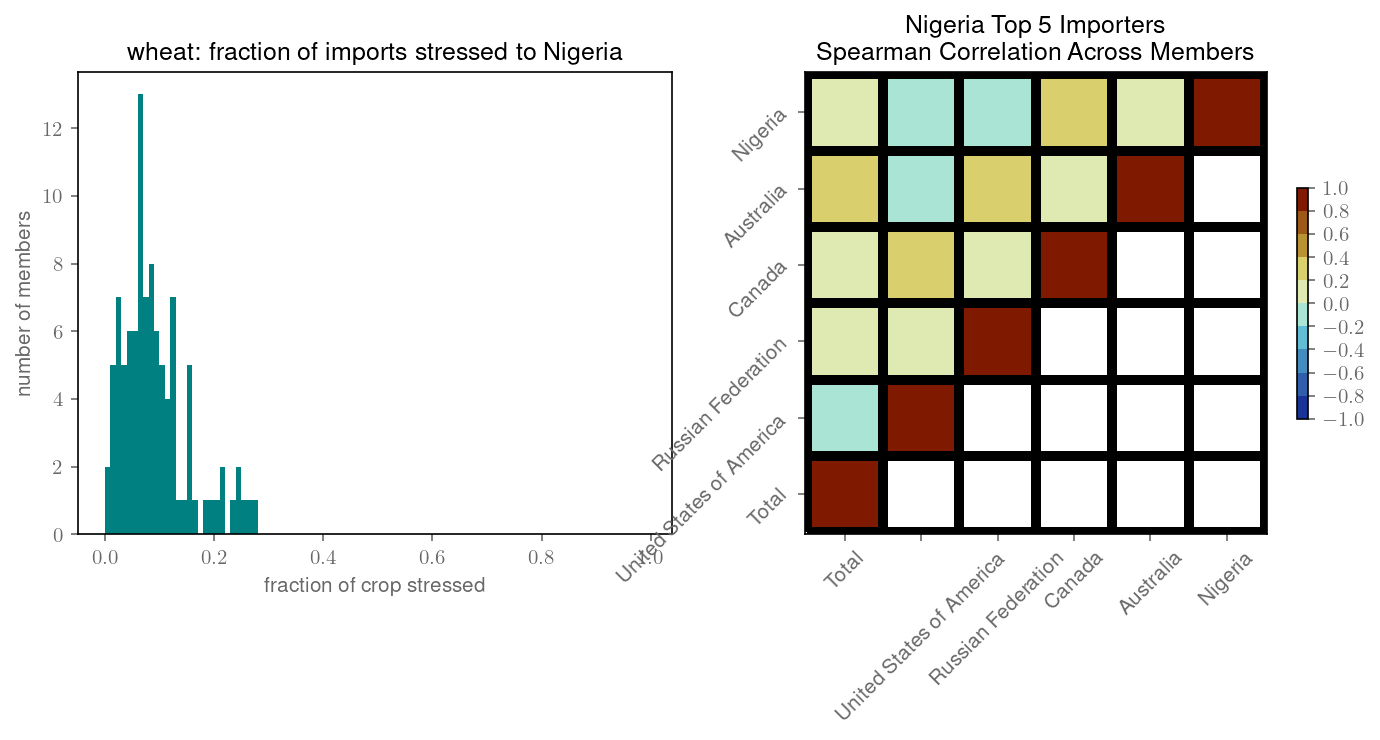

In [10]:
imp.reload(plots)
imp.reload(data_processing)

data_trade, reporter_code_list, n_partners = cropstress.get_trade_data(settings)
bins = np.arange(0, 1.0, 0.01)
REPORTER_COUNTRY_LIST = (
    # "ner",
    # "nga",
    # "bra",
    "nga",
    # "chn",
    # "tcd"
)  # "arm", "gbr", "hrv", "nzl", "usa", "fra", "egy")
for reporter_country in REPORTER_COUNTRY_LIST:
    irep = np.where(reporter_code_list == reporter_country)[0]
    reporter_country_name = data_processing.get_name_from_code(
        [
            reporter_country,
        ]
    )
    df_reporter = data_trade[data_trade["Destination"] == reporter_country].reset_index(
        drop=True
    )
    partner_code_list = df_reporter["Source"].values
    ip = np.where(partner_code_list == reporter_code)[0]

    # make the plots
    plt.figure(figsize=(5 * 4.5 * 0.5, 4), dpi=150)

    plt.subplot(1, 2, 1)
    xplot = np.nansum(traded_stress[irep, :, :], axis=-1)
    plt.hist(xplot[0, :], bins, color="teal")
    plt.title(crop_name + ": fraction of imports stressed to " + reporter_country_name)
    plt.ylabel("number of members")
    plt.xlabel("fraction of crop stressed")

    plt.subplot(1, 2, 2)

    cov_data = plots.plot_import_cov(
        reporter_country,
        df_reporter,
        traded_stress[irep, :, ip],
        traded_stress[irep, :, :][0, :, :],
        settings["trade_data_year"],
    )

    plots.savefig(
        FIGURE_DIRECTORY
        + settings["exp_name"]
        + "_"
        + reporter_country
        + "_"
        + settings["product"]
        + "_imported_reporter_relationships"
    )
    plt.show()

In [ ]:
raise ValueError()

## Method Schematic

In [ ]:
SCHEMATIC_COUNTRY_CODE = "bra"
SCHEMATIC_COUNTRY_NAME = data_processing.get_name_from_code((SCHEMATIC_COUNTRY_CODE,))
SCHEMATIC_COUNTRY_LIST = (
    SCHEMATIC_COUNTRY_NAME,
    "United States of America",
    "Paraguay",
    "Argentina",
)
SCHEMATIC_COUNTRY_INDEX = np.where(reporter_code_list == SCHEMATIC_COUNTRY_CODE)[0][0]
SCHEMATIC_MEMBER = 8
REG_BNDS = [360 - 120, 360 - 40, -55, 50]

In [ ]:
# SCHEMATIC_COUNTRY_CODE = "egy"
# SCHEMATIC_COUNTRY_NAME = data_processing.get_name_from_code((SCHEMATIC_COUNTRY_CODE,))
# SCHEMATIC_COUNTRY_LIST = (SCHEMATIC_COUNTRY_NAME, "Russia", "Ukraine",)
# SCHEMATIC_COUNTRY_INDEX = np.where(reporter_code_list == SCHEMATIC_COUNTRY_CODE)[0][0]
# SCHEMATIC_MEMBER = 8
# REG_BNDS = [30, 90, 0, 55]

In [ ]:
# SCHEMATIC_COUNTRY_CODE = "nga"
# SCHEMATIC_COUNTRY_NAME = data_processing.get_name_from_code((SCHEMATIC_COUNTRY_CODE,))
# SCHEMATIC_COUNTRY_LIST = (SCHEMATIC_COUNTRY_NAME, "United States of America", "Russia", "Canada", "Australia")
# SCHEMATIC_COUNTRY_INDEX = np.where(reporter_code_list == SCHEMATIC_COUNTRY_CODE)[0][0]
# SCHEMATIC_MEMBER = 8
# REG_BNDS = [30, 90, 0, 55]

In [ ]:
# get trade data
data_trade, reporter_code_list, n_partners = cropstress.get_trade_data(settings)
da_crop_area = data_processing.get_cropped_area_mask(CROP_DIRECTORY, settings)

map_partner_fraction = data.copy() * 0.0
map_schematic_summary = data.copy() * 0.0
map_schematic_trade_summary = data.copy() * 0.0

for irep, reporter_code in enumerate(reporter_code_list):
    if reporter_code != SCHEMATIC_COUNTRY_CODE:
        continue
    print(irep)

    # GET REPORTER DATA
    data_reporter = data_trade[data_trade["Destination"] == reporter_code]

    reporter_name = data_processing.get_name_from_code(
        (data_reporter["Destination"].values[0],)
    )
    reporter_import_dollars = data_reporter["TotValue"].sum()
    print(
        f"{reporter_code}, {reporter_name}, ${reporter_import_dollars:.3f},",
        end=" ",
        flush=True,
    )

    # GET PARTNER NAMES and DOLLARS
    dollars = data_reporter["TotValue"].values
    partner_code_list = data_reporter["Source"].values
    print(f"n_partners = {len(np.unique(partner_code_list))},", end="\n", flush=True)
    assert len(np.unique(partner_code_list)) == len(partner_code_list)

    mask_partner_crop_total = np.zeros(da_crop_area.shape)

    for ip, partner_code in enumerate(partner_code_list):
        partner_trade_frac = dollars[ip] / reporter_import_dollars

        if partner_trade_frac == 0 or np.isin(
            partner_code, settings["exclude_regions"]
        ):
            continue

        if partner_trade_frac < 0.03:
            # if partner_trade_frac < 0.06:
            continue
        print(partner_code, partner_trade_frac)

        # find partner in shbapefile dataframe for geographic points
        mask_partner = data_processing.create_country_mask(
            partner_code, regs_shp, mask_country
        )

        # further mask the partner and reporter by cropped area
        mask_partner_crop = mask_partner * da_crop_area
        mask_partner_crop_total = mask_partner_crop_total + xr.where(
            np.isnan(mask_partner_crop), 0.0, mask_partner_crop
        )

        # RESPONSE CALCULATIONS ACROSS MAPS over CROP AREA ONLY
        crop_response = data_processing.compute_global_sum(
            data
            * mask_partner_crop
            / data_processing.compute_global_sum(mask_partner_crop)
        )
        traded_stress_schematic = crop_response * partner_trade_frac
        print(
            crop_response[SCHEMATIC_MEMBER].values.round(3),
            traded_stress_schematic[SCHEMATIC_MEMBER].values.round(3),
        )

        # fill the trade map
        map_partner_fraction = cropstress.fill_map(
            map_partner_fraction, mask_partner, partner_trade_frac
        )
        # fill the trade map
        map_schematic_summary = cropstress.fill_map(
            map_schematic_summary, mask_partner, np.asarray(crop_response)
        )
        # fill the trade map
        map_schematic_trade_summary = cropstress.fill_map(
            map_schematic_trade_summary,
            mask_partner,
            np.asarray(traded_stress_schematic),
        )

    mask_partner_crop_total = xr.where(
        mask_partner_crop_total == 0, np.nan, mask_partner_crop_total
    )
    map_partner_fraction = xr.where(
        map_partner_fraction == 0, np.nan, map_partner_fraction
    )
    map_schematic_summary = xr.where(
        map_schematic_summary == 0, np.nan, map_schematic_summary
    )
    map_schematic_trade_summary = xr.where(
        map_schematic_trade_summary == 0, np.nan, map_schematic_trade_summary
    )

In [ ]:
# PLOT CROPS [A]
imp.reload(plots)

plots.schematic_maps(
    mask_partner_crop_total * 100,
    data.lat,
    data.lon,
    cmap="gist_earth_r",
    vmin=-0.005 * 100,
    vmax=0.2 * 100,
    xticks=(0, 10, 20),
    xticklabels=("0", "10", "20 \%"),
    country_list=SCHEMATIC_COUNTRY_LIST,
    reg_bnds=REG_BNDS,
)

plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_Brazil_crop_schematic_"
    + settings["product"],
    fig_format=(".png", ".pdf"),
)

plt.show()

In [ ]:
# PLOT STRESS [B]
imp.reload(plots)
data_plot = xr.where(data == 0, np.nan, data)
plots.schematic_maps(
    data_plot[SCHEMATIC_MEMBER, :, :],
    data.lat,
    data.lon,
    cmap="Reds",
    vmin=0.0,
    vmax=1.5,
    xticks=(0, 1.5),
    xticklabels=("not\nstressed", "stressed"),
    country_list=SCHEMATIC_COUNTRY_LIST,
    reg_bnds=REG_BNDS,
)
plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_Brazil_stress_schematic_"
    + settings["product"],
    fig_format=(".png", ".pdf"),
)
plt.show()

In [ ]:
imp.reload(plots)
cmap = palettable.cmocean.sequential.Matter_10.mpl_colormap
plots.schematic_maps(
    map_schematic_summary[SCHEMATIC_MEMBER, :, :] * 100,
    data.lat,
    data.lon,
    cmap=cmap,
    vmin=0.0,
    vmax=100,
    xticks=(0, 50, 100),
    xticklabels=("0", "50", "100 \%"),
    country_list=SCHEMATIC_COUNTRY_LIST,
    reg_bnds=REG_BNDS,
)

plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_Brazil_response_schematic_"
    + settings["product"],
    fig_format=(".png", ".pdf"),
)
plt.show()

In [ ]:
imp.reload(plots)
cmap = palettable.cmocean.sequential.Dense_10.mpl_colormap
plots.schematic_maps(
    map_partner_fraction[SCHEMATIC_MEMBER, :, :] * 100,
    data.lat,
    data.lon,
    cmap=cmap,
    vmin=0.0,
    vmax=100,
    xticks=(0, 50, 100),
    xticklabels=("0", "50", "100 \%"),
    country_list=SCHEMATIC_COUNTRY_LIST,
    reg_bnds=REG_BNDS,
)

plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_Brazil_partnerfrac_schematic_"
    + settings["product"],
    fig_format=(".png", ".pdf"),
)
plt.show()

In [ ]:
imp.reload(plots)
cmap = palettable.cmocean.sequential.Matter_10.mpl_colormap
plots.schematic_maps(
    map_schematic_trade_summary[SCHEMATIC_MEMBER, :, :] * 100,
    data.lat,
    data.lon,
    cmap=cmap,
    vmin=0.0,
    vmax=100,
    xticks=(0, 50, 100),
    xticklabels=("0", "50", "100 \%"),
    country_list=SCHEMATIC_COUNTRY_LIST,
    reg_bnds=REG_BNDS,
)

plots.savefig(
    FIGURE_DIRECTORY
    + settings["exp_name"]
    + "_Brazil_tradestress_schematic_"
    + settings["product"],
    fig_format=(".png", ".pdf"),
)
plt.show()